# OpenStreetMap Wrangle & Case Study
---

This case study is carried out using OpenStreetMap data on an area of LA spanning: Downtown, Koreatown and Exposition Park (see image below). I have previously lived in that area and it is great to see what kind of improvements could be added to the online data.

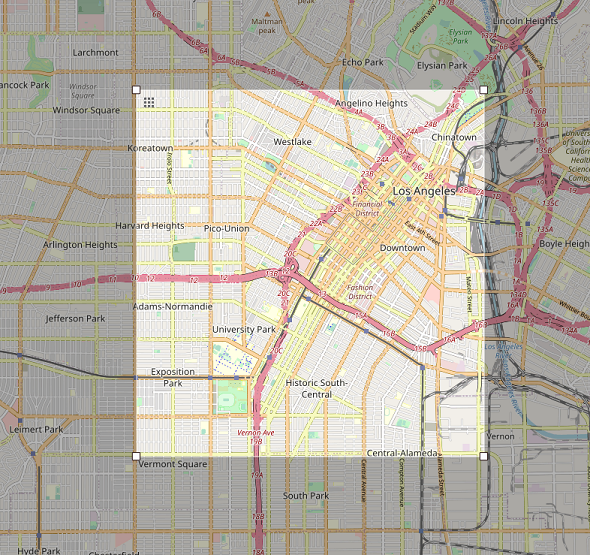

## Problems encountered with Map

An OSM file of the area was downloaded using the OpenStreetMap API request tool. The OSM XML data was then parsed into Python data structures to catch out problematic data points for cleaning. This was intially done to a smaller portion of the data ~4 MB and then was expanded to the full dataset.

First thing that stood out was that some street names were very inconsistent. For example the word street was recorded in four different abbreviated forms:

<ul>
<li>St</li>
<li>st</li>
<li>St.</li>
<li>Str</li>
</ul>

There were also instances were the full word was mispelled to be "Sreet" instead of "Street". This was seen for plenty of other variations (e.g Ave for Avenue). All abbreviations and misspellings were all corrected with the full forms of addresses.

Another issue encountered was incorrect address lines inputted as street names. For instance:

<ul>
<li>18th Floor: which is a different line of address but not the street name</li>
<li>Ducommun: which is a company name but errorneously included as a street name</li>
</ul>

## Correction function

```Python
def update_name(name_ofStreet, mapping):
    
    namelist=name_ofStreet.split()
    new_name=""
        
    #fixing abbreviations
    for ii in range(len(namelist)):
        word=namelist[ii] 
        if word in mapping:
            word=mapping[word]      
        new_name=new_name+word+" "
        
    #fixing adding the second line of address to the code (by looking for commas or semi colons)
    #if checks if there is a string that is unexpected that has been fixed in the last loop
    if namelist[-1] in st_types and namelist[-1] in new_name:
        new_name=""
        for jj in range(len(namelist)):
            word=namelist[jj] 
            if word.endswith(',') or word.endswith(';'):
                word=word.strip(',;')
                new_name=new_name+word+" "
                return new_name
            else:
                new_name=new_name+word+" "
                 
    return new_name
```

The function update_name() was used to systematically correct the errors identified above when parsing the XML file. It uses the dictionary defined (mapping) to remove the identified "problematic" names and replace them with the desired results.

The first loop fixes problems with abbreviations in street names. While the second part scans if there are strings that include an extra line of address (building or suite for example). It then removes that second line of address and only keeps the street name.

## Overview of the Data

In [80]:
#importing required packages for sql
import sqlite3
import pandas as pd
from pandas import DataFrame

#Connect to Database
db_name="downtownEx.db"
conn = sqlite3.connect(db_name)
c = conn.cursor()

In [81]:
#function to print using pandas dataframe

def fetchaPrint():
    df = DataFrame(c.fetchall())
    print df
    return

### File Sizes

<b>OSM (downloaded from OpenStreetMap API)</b>

downtownExtended.osm    155 MB

<b>CSVs (used to create database)</b>

nodes.csv               58 MB<br>
nodes_tags.csv          0.89 MB<br>
ways.csv                4.5 MB<br>
ways_tags.csv           14.8 MB<br>
ways_nodes.cv           18 MB<br>

<b>Database</b> <br>
downtownEx.db           83 MB




### Number of Unique Users

In [82]:
c.execute('''
SELECT COUNT(DISTINCT(e.uid))          
FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e''')
#credit to CarlWard (GIT)
fetchaPrint()

     0
0  974


### Number of Nodes

In [83]:
c.execute('''
SELECT COUNT(*) FROM nodes;''')

fetchaPrint()

        0
0  644058


### Number of Ways

In [84]:
c.execute('''
SELECT COUNT(*) FROM ways;''')

fetchaPrint()

       0
0  70838


### Top 10 appearing amenities

In [85]:
c.execute('''
SELECT value, COUNT(*) as num
FROM nodes_tags
WHERE key='amenity' 
GROUP BY value
ORDER BY num DESC
LIMIT 10;''')

fetchaPrint()

                  0    1
0        restaurant  346
1  place_of_worship  102
2              cafe   93
3         fast_food   80
4            school   57
5    bicycle_rental   54
6               bar   42
7   bicycle_parking   40
8  parking_entrance   39
9             bench   37


## Other ideas about the dataset

### Wheel Chair Access for Restaurants/ Amenities Suggestion

In [86]:
c.execute('''
SELECT nodes_tags.key, nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='amenity' OR nodes_tags.key='wheelchair'
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 50;''')

fetchaPrint()

            0           1    2
0     amenity  restaurant  346
1  wheelchair         yes   12
2  wheelchair     limited    2
3  wheelchair          no    1


>The query above shows the only ~3.5% of restaurants have wheel chair access (at least that is reported by Open Street Map). It is highly likely that there are more places that have wheelchair access. Since this is an important feature to show on the map, it should be stressed that such information should be shown on entries (this is not necessarily for restaurants only but for other amenities too).

In addition on the Open Street Map interface such feature is not well highlighted for entities. It would be good if the interface is updated to show wheelchair access more clearly. It is worthy to mention that such data might not be easy to obtain and will require manual input. However it would be worth to include it as "unknown" if it is not entered so that the information is there.

### Starbucks rules the branded coffee scene

In [87]:
c.execute('''
SELECT nodes_tags.key, nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='cafe') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='brand'
GROUP BY nodes_tags.value
ORDER BY num DESC
''')

fetchaPrint()

       0                   1   2
0  brand           Starbucks  21
1  brand  Blue Bottle Coffee   2
2  brand       Peet's Coffee   1


## Are there more gyms and yoga centres than churchs in LA?

### Number of Churches

In [88]:
c.execute('''
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='place_of_worship') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='religion'
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 1''')

fetchaPrint()


           0   1
0  christian  90


### How Many Yoga Places

In [89]:
c.execute('''
SELECT nodes_tags.key, nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags) i
    ON nodes_tags.id=i.id
WHERE (nodes_tags.value LIKE '%yoga%') AND (nodes_tags.key='brand' OR nodes_tags.key='name')
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 70;''')

fetchaPrint()
#WHERE nodes_tags.value LIKE '%yoga%' OR nodes_tags.value LIKE '%gym%' OR nodes_tags.value LIKE '%fitness%'

       0                          1  2
0  brand             CorePower Yoga  4
1   name                  Soho Yoga  1
2   name                 Evoke Yoga  1
3   name  Bikram Yoga Downtown L.A.  1


### How Many Fitness Centres?

In [90]:
c.execute('''
SELECT nodes_tags.key, nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags) i
    ON nodes_tags.id=i.id
WHERE nodes_tags.value='fitness_centre'
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 70;''')

fetchaPrint()

         0               1   2
0  leisure  fitness_centre  19


> <b>Surprisingly there is still more churches than yoga centres and fitness centres around Downtown LA! </b>